# Reading & Writing Rasters with Rasterio 

In this tutorial series, we'll work with raster data using `rasterio` and later `rioxarray`. 
Behind the scenes, `numpy.ndarray` handles the heavy computational work. To understand how 
rasters work, we'll start by constructing one from scratch and then work with real satellite imagery.

This chapter establishes our core dataset that we'll use throughout the entire tutorial series,
ensuring continuity and building complexity as we progress through different raster operations.

## Creating Synthetic Raster Data

Let's begin by creating coordinate arrays. Here we create two `ndarray` objects: 
`X` spans [-90°,90°] longitude, and `Y` covers [90°,-90°] latitude.

In [1]:
import numpy as np

# Create coordinate arrays
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

print("Longitude array (X):")
print(X)
print("\nLatitude array (Y):")
print(Y)

Longitude array (X):
[[-90. -54. -18.  18.  54.  90.]
 [-90. -54. -18.  18.  54.  90.]
 [-90. -54. -18.  18.  54.  90.]
 [-90. -54. -18.  18.  54.  90.]
 [-90. -54. -18.  18.  54.  90.]
 [-90. -54. -18.  18.  54.  90.]]

Latitude array (Y):
[[ 90.  90.  90.  90.  90.  90.]
 [ 54.  54.  54.  54.  54.  54.]
 [ 18.  18.  18.  18.  18.  18.]
 [-18. -18. -18. -18. -18. -18.]
 [-54. -54. -54. -54. -54. -54.]
 [-90. -90. -90. -90. -90. -90.]]


Now let's generate some synthetic temperature data and visualize it:

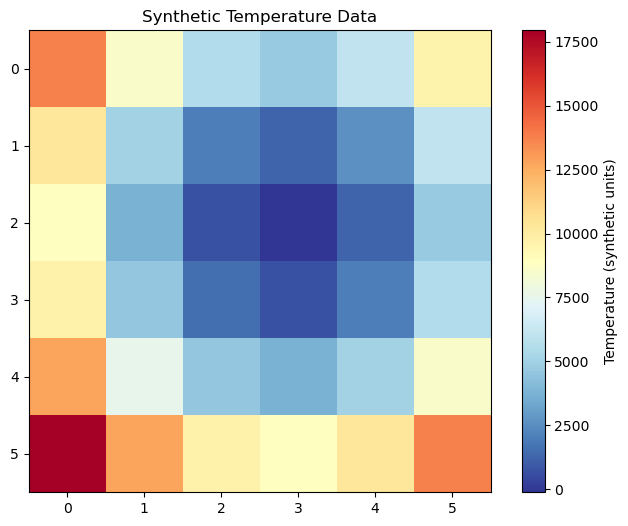

Temperature data shape: (6, 6)
Temperature data type: float64


In [2]:
import matplotlib.pyplot as plt

# Generate synthetic temperature data
Z1 = np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 = np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z = (Z1 - Z2)

plt.figure(figsize=(8, 6))
plt.imshow(Z, cmap="RdYlBu_r")
plt.colorbar(label="Temperature (synthetic units)")
plt.title("Synthetic Temperature Data")
plt.show()

print("Temperature data shape:", Z.shape)
print("Temperature data type:", Z.dtype)

## Understanding Raster Components

The array `Z` contains our data values, but to make it a true spatial raster dataset 
usable by `rasterio`, we need additional spatial information. A complete raster requires:

| Component     | Description    | Our Value      |
| :---          | ---:           |---:        |
| **driver**    | File format driver   |  `'GTiff'` |
| **width**     | Number of columns   |  `Z.shape[1]` |
| **height**    | Number of rows   |  `Z.shape[0]` |
| **count**     | Number of bands   |  `1` |
| **dtype**     | Data type   |  `Z.dtype` |
| **crs**       | Coordinate reference system   |  `'EPSG:4326'`|
| **transform** | Affine transformation matrix   |  *calculated below*|
| **nodata**    | No-data value   |  `-9999`|

The **transform** defines the raster's location on Earth and its spatial resolution. 
It maps pixel coordinates to geographic coordinates.

## Writing Our First Raster

Let's save our synthetic temperature data as a proper georeferenced raster file:

In [3]:
import rasterio
from rasterio.transform import Affine
import os

# Calculate spatial resolution
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)

print(f"X resolution: {xres}°")
print(f"Y resolution: {yres}°")

# Create the affine transformation
# This positions the raster in geographic space
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

print(f"Transform matrix:\n{transform}")

# Define our primary output file for the tutorial series
output_file = "../../pygis/temp/temperature.tif"

# Force delete if exists to avoid permission errors
if os.path.exists(output_file):
    try:
        os.remove(output_file)
        print(f"Removed existing file: {output_file}")
    except PermissionError:
        print(f"Warning: Cannot delete {output_file} - file may be open in another program")

# Write the raster with complete spatial information
with rasterio.open(
        output_file,
        mode="w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        crs="EPSG:4326",  # WGS84 geographic coordinate system
        transform=transform,
        nodata=-9999,
        compress="lzw"  # Add compression for efficiency
) as new_dataset:
        new_dataset.write(Z, 1)

print(f"Successfully created: {output_file}")
print("This file will be used in subsequent chapters for reprojection and resampling.")

X resolution: 30.0°
Y resolution: -30.0°
Transform matrix:
| 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|
Removed existing file: ../../pygis/temp/temperature.tif
Successfully created: ../../pygis/temp/temperature.tif
This file will be used in subsequent chapters for reprojection and resampling.


## Reading Raster Data

Now let's read our raster back and examine its properties:

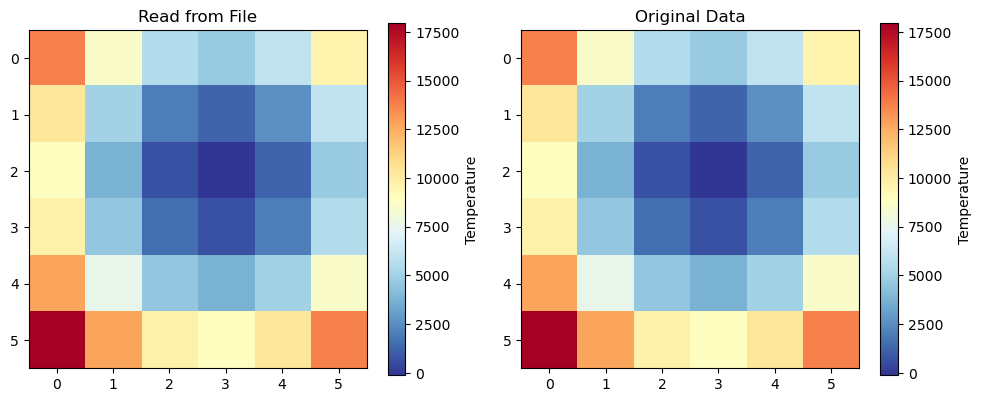

Data matches original: True


In [6]:
# Read back our created raster
raster = rasterio.open(output_file)

# Display the data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(raster.read(1), cmap="RdYlBu_r")
plt.colorbar(label="Temperature")
plt.title("Read from File")

# Compare with original
plt.subplot(1, 2, 2)
plt.imshow(Z, cmap="RdYlBu_r")
plt.colorbar(label="Temperature")
plt.title("Original Data")

plt.tight_layout()
plt.show()

# Verify they match
data_from_file = raster.read(1)
print("Data matches original:", np.array_equal(Z, data_from_file))

## Examining Raster Metadata

The `.profile` contains all the spatial and technical information about our raster:

In [7]:
print("Raster Profile:")
print("=" * 40)
for key, value in raster.profile.items():
    print(f"{key:12}: {value}")

print(f"\nBounds: {raster.bounds}")
print(f"Coordinate Reference System: {raster.crs}")
print(f"Transform:\n{raster.transform}")

Raster Profile:
driver      : GTiff
dtype       : float64
nodata      : -9999.0
width       : 6
height      : 6
count       : 1
crs         : EPSG:4326
transform   : | 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|
blockxsize  : 6
blockysize  : 6
tiled       : False
compress    : lzw
interleave  : band

Bounds: BoundingBox(left=-105.0, bottom=-75.0, right=75.0, top=105.0)
Coordinate Reference System: EPSG:4326
Transform:
| 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|


## Working with Real Satellite Data

Now let's work with actual Landsat 8 imagery. This will be our primary satellite dataset 
for the remainder of the tutorial series:

In [9]:
# Define our primary Landsat file for the tutorial series
landsat_file = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

# Open and examine the Landsat data
with rasterio.open(landsat_file) as src:
    print("Landsat 8 Image Properties:")
    print("=" * 40)
    profile = src.profile
    for key, value in profile.items():
        print(f"{key:12}: {value}")
    
    print(f"\nBounds: {src.bounds}")
    print(f"Number of bands: {src.count}")
    print(f"Band descriptions: {[src.descriptions[i] for i in range(src.count)]}")

Landsat 8 Image Properties:
driver      : GTiff
dtype       : uint16
nodata      : None
width       : 2041
height      : 1860
count       : 3
crs         : EPSG:32621
transform   : | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00|
blockxsize  : 256
blockysize  : 256
tiled       : True
compress    : lzw
interleave  : pixel

Bounds: BoundingBox(left=717345.0, bottom=-2832795.0, right=778575.0, top=-2776995.0)
Number of bands: 3
Band descriptions: [None, None, None]


This Landsat image has several issues that we'll address in this series:
1. Bands are in BGR order instead of RGB
2. Values are scaled by 100 (need to divide by 100)
3. Zero values should be treated as no-data
4. The image may need reprojection for analysis

Let's examine the data values:

In [10]:
with rasterio.open(landsat_file) as src:
    # Read the first three bands
    bands = src.read([1, 2, 3])  # Blue, Green, Red
    
    print("Band statistics:")
    print("=" * 30)
    for i, band_data in enumerate(bands):
        print(f"Band {i+1}:")
        print(f"  Min: {band_data.min()}")
        print(f"  Max: {band_data.max()}")
        print(f"  Mean: {band_data.mean():.2f}")
        print(f"  Zeros: {np.sum(band_data == 0)} pixels")

Band statistics:
Band 1:
  Min: 0
  Max: 20230
  Mean: 6514.66
  Zeros: 627031 pixels
Band 2:
  Min: 0
  Max: 21671
  Mean: 6110.76
  Zeros: 627031 pixels
Band 3:
  Min: 0
  Max: 24147
  Mean: 5660.51
  Zeros: 627031 pixels


## Processing the Landsat Data

Let's create a properly processed version of our Landsat data that we'll use 
throughout the tutorial series:

In [11]:
# Our target processed file for the tutorial series
processed_landsat = "../../pygis/temp/tutorial_landsat_processed.tif"

with rasterio.open(landsat_file) as src:
    # Read bands in correct order: Red(3), Green(2), Blue(1)
    arr = src.read([3, 2, 1])
    
    # Scale the data (divide by 100 as per Landsat Collection 1 specifications)
    scaled_arr = arr.astype(np.float32) / 100.0
    
    # Update profile for the processed version
    profile = src.profile.copy()
    profile.update({
        'dtype': scaled_arr.dtype,
        'nodata': 0.0,
        'compress': 'lzw'
    })
    
    # Write the processed Landsat data
    with rasterio.open(processed_landsat, 'w', **profile) as dst:
        dst.write(scaled_arr)

print(f"Created processed Landsat file: {processed_landsat}")
print("This RGB-ordered, scaled dataset will be used in subsequent chapters.")

Created processed Landsat file: ../../pygis/temp/tutorial_landsat_processed.tif
This RGB-ordered, scaled dataset will be used in subsequent chapters.


## Quick Visualization of Processed Data

Let's verify our processed Landsat data looks correct:

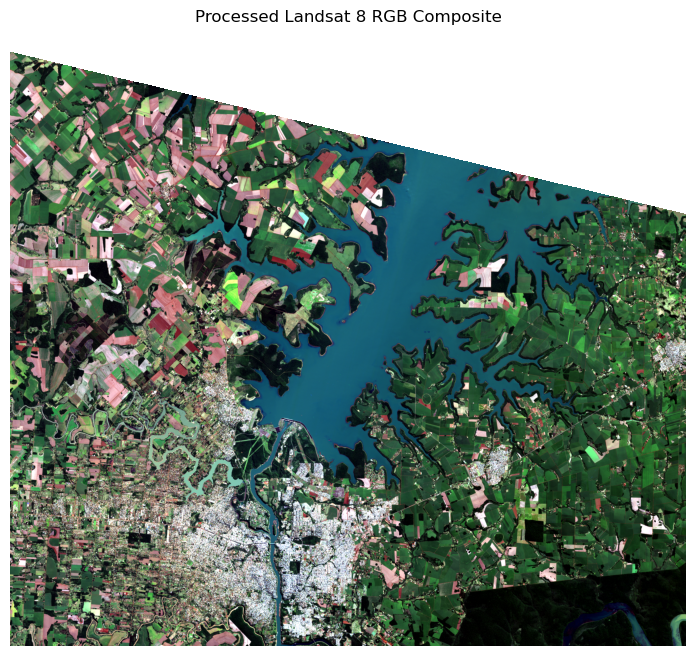

In [13]:
import numpy as np

# Read and display the processed data
with rasterio.open(processed_landsat) as src:
    rgb_data = src.read()
    
    # Remove no-data values and create RGB composite
    rgb_clean = np.where(rgb_data == 0, np.nan, rgb_data)
    
    # Apply simple contrast stretch (2-98 percentile)
    def normalize_band(band):
        valid_data = band[~np.isnan(band)]
        p2, p98 = np.percentile(valid_data, (2, 98))
        return np.clip((band - p2) / (p98 - p2), 0, 1)
    
    rgb_normalized = np.stack([normalize_band(rgb_clean[i]) for i in range(3)])
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_normalized.transpose(1, 2, 0))
    plt.title("Processed Landsat 8 RGB Composite")
    plt.axis('off')
    plt.show()

## Chapter Summary

In this chapter, we created two primary datasets for the tutorial series:

- `tutorial_temperature.tif` - Synthetic temperature data for basic operations
- `tutorial_landsat_processed.tif` - Processed Landsat 8 RGB data for advanced analysis

These files will be used consistently in subsequent chapters for reprojection, resampling, and analysis operations.

In [14]:
raster.close()
print("Chapter 1 complete. Files ready for Chapter 2.")

Chapter 1 complete. Files ready for Chapter 2.
